In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "models":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [61]:
import logging
from datetime import datetime
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import optuna
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from icecream import ic
from polars import col
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, TensorDataset

from src.data.database_manager import DatabaseManager
from src.features.utils import to_describe
from src.log_config import configure_logging
from src.models.utils import StandardScaler3D

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

db = DatabaseManager()

In [3]:
with db:
    labels = db.get_table("Labels")
    eda = db.get_table("Feature_EDA")

In [4]:
eda.hvplot(x="timestamp", y=["eda_raw"], groupby="trial_id", width=800, height=400)

BokehModel(combine_events=True, render_bundle={'docs_json': {'39a3b0bd-9afd-47fb-a213-be2eec995c04': {'version…

In [5]:
labels = labels.with_columns(
    # Add time counter for decreases and strictly increases
    (
        pl.when(col("strictly_increasing_intervals") != 0)
        .then(
            col("timestamp")
            - col("timestamp").min().over("strictly_increasing_intervals")
        )
        .otherwise(None)
    ).alias("normalized_timestamp_increases"),
    (
        pl.when(col("decreasing_intervals") != 0)
        .then(col("timestamp") - col("timestamp").min().over("decreasing_intervals"))
        .otherwise(None)
    ).alias("normalized_timestamp_decreases"),
    # Only keep the first 5 seconds
).filter(
    (col("normalized_timestamp_increases") < 5000)
    | (col("normalized_timestamp_decreases") < 5000)
)
labels

trial_id,trial_number,participant_id,rownumber,timestamp,temperature,rating,stimulus_seed,skin_area,normalized_timestamp,decreasing_intervals,major_decreasing_intervals,increasing_intervals,plateau_intervals,prolonged_minima_intervals,strictly_increasing_intervals,normalized_timestamp_increases,normalized_timestamp_decreases
u16,u8,u8,u32,f64,f64,f64,u16,u8,f64,u16,u16,u16,u16,u16,u16,f64,f64
1,1,1,320,326250.8398,0.80056,0.83375,396,1,32026.5088,1,0,0,0,0,0,null,0.0
1,1,1,321,326351.5703,0.800524,0.83375,396,1,32127.2393,1,0,0,0,0,0,null,100.7305
1,1,1,322,326453.3964,0.800415,0.8375,396,1,32229.0654,1,0,0,0,0,0,null,202.5566
1,1,1,323,326551.3829,0.800232,0.83875,396,1,32327.0519,1,0,0,0,0,0,null,300.5431
1,1,1,324,326651.1161,0.799977,0.83875,396,1,32426.7851,1,0,0,0,0,0,null,400.2763
1,1,1,325,326751.5133,0.799649,0.83875,396,1,32527.1823,1,0,0,0,0,0,null,500.6735
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332,12,28,21586,2.7746e6,0.25889,0.80625,133,1,177496.8039,1660,0,0,0,0,0,null,4403.8851
332,12,28,21587,2.7747e6,0.251239,0.80625,133,1,177596.5374,1660,0,0,0,0,0,null,4503.6186


In [6]:
# Split data into decreasing and increasing intervals to add labels and sample ids
decreases = labels.filter(
    col("normalized_timestamp_decreases").is_not_null()
).with_columns(
    pl.lit(1).alias("label").cast(pl.UInt8),
    col("decreasing_intervals").alias("sample_id"),
)

In [7]:
increases = labels.filter(
    col("normalized_timestamp_increases").is_not_null()
).with_columns(
    pl.lit(0).alias("label").cast(pl.UInt8),
    (
        col("strictly_increasing_intervals")
        + (decreases.select(pl.last("decreasing_intervals")))  # continue from decreases
    ).alias("sample_id"),
)

In [8]:
# Join the two tables
labels = decreases.vstack(increases).sort("sample_id", "timestamp")

In [9]:
# Normalize the data
ROWS_PER_SAMPLE = 50

labels = (
    labels.sort(["sample_id"])  # Sort within each group if needed
    .group_by("sample_id", maintain_order=True)
    .agg(pl.all().head(ROWS_PER_SAMPLE))
    .explode(pl.all().exclude("sample_id"))  # Explode the result back into rows
)

labels.select(pl.last("sample_id")).item() * ROWS_PER_SAMPLE, labels.height

(132800, 132796)

In [10]:
# Sanity check
if not labels.height == labels.select(pl.last("sample_id")).item() * ROWS_PER_SAMPLE:
    affected_samples = []
    for sample_id, group in labels.group_by("sample_id", maintain_order=True):
        if group.height < ROWS_PER_SAMPLE or group.height > ROWS_PER_SAMPLE:
            affected_samples.append(sample_id[0])  # sample_id is a tuple
logging.debug(
    f"Normalizing to equal {ROWS_PER_SAMPLE} rows per sample was not successful for the following samples: {affected_samples}"
)
labels = labels.filter(~col("sample_id").is_in(affected_samples))

12:09:42 | DEBUG   | root | Normalizing to equal 50 rows per sample was not successful for the following samples: [1310, 2143, 2428, 2641]


In [11]:
labels = labels.select(
    "sample_id",
    "participant_id",
    "rating",
    "label",
)
labels

sample_id,participant_id,rating,label
u16,u8,f64,u8
1,1,0.83375,1
1,1,0.83375,1
1,1,0.8375,1
1,1,0.83875,1
1,1,0.83875,1
1,1,0.83875,1
…,…,…,…
2656,28,0.66375,0
2656,28,0.6675,0


In [84]:
# x has the dimensions (samples, time steps, features)
X = labels.group_by("sample_id").agg("rating").get_column("rating").to_numpy()
# reshaping the array
# NOTE: for univariate data right now, need to be adapted for multivariate
X = np.vstack(X)
X = np.expand_dims(X, axis=2)
y = (
    labels.group_by("sample_id")
    .agg((col("label").first()))
    .get_column("label")
    .to_numpy()
)
groups = (
    labels.group_by("sample_id")
    .agg((col("participant_id").first()))
    .get_column("participant_id")
    .to_numpy()
)

In [85]:
# np.save("data/x.npy", x)
# np.save("data/y.npy", y)
# np.save("data/groups.npy", groups)

In [86]:
device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else torch.device("mps")
    if torch.backends.mps.is_available()
    else torch.device("cpu")
)
logging.debug(f"Using device: {device}")


14:40:52 | DEBUG   | root | Using device: mps


In [87]:
class MLP(nn.Module):
    """MLP class for time series classification with 3D input"""

    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Permute to Fortran order
        x = x.flatten(start_dim=1)  # Flatten to 2D
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out  # BCEWithLogitsLoss will apply sigmoid


models_dict = {
    "MLP": {
        "class": MLP,
        "format": "2D",
        "hyperparameters": {
            "hidden_size": {"type": "int", "low": 128, "high": 4096},
            "lr": {"type": "float", "low": 1e-5, "high": 1e-1, "log": True},
            "batch_size": {"type": "categorical", "choices": [32, 64, 128]},
        },
    }
}

In [121]:
lr = 1e-3
batch_size = 64
model = MLP(
    input_size=X.shape[2] * X.shape[1],  # 2D input or something like that TODO
    hidden_size=1024,
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [89]:
# Split the data into training+validation set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


def create_dataloaders(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size,
    is_validation=False,
):
    if not len(X_train.shape) == len(X_test.shape) == 3:
        raise ValueError(
            "X_train and X_test must have 3 dimensions: (samples, timesteps, features)"
        )

    scaler = StandardScaler3D()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    train_data = TensorDataset(
        torch.FloatTensor(X_train),
        torch.FloatTensor(y_train).view(-1, 1),
    )
    test_data = TensorDataset(
        torch.FloatTensor(X_test),
        torch.FloatTensor(y_test).view(-1, 1),
    )

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    data_set = "Validation" if is_validation else "Test"
    logging.debug(
        f"Train Data: {len(train_data)} samples, {data_set} Data: {len(test_data)} samples"
    )

    return train_loader, test_loader


train_loader, test_loader = create_dataloaders(
    X_train,
    y_train,
    X_test,
    y_test,
    batch_size=batch_size,
)


14:40:53 | DEBUG   | root | Train Data: 2121 samples, Test Data: 531 samples


In [117]:
# NOTE: renamed test_loader from val_loader
def train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs,
    is_test=True,
):
    history = {
        "train_accuracy": [],
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": [],
    }

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # for acc metric only
        correct = 0
        total = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

            # Calculate training accuracy
            y_pred_classes = (torch.sigmoid(outputs) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total if total > 0 else 0
        val_loss, val_accuracy = evaluate_model(model, test_loader, criterion)

        # Store the metrics in the history dictionary
        history["train_loss"].append(epoch_loss)
        history["train_accuracy"].append(epoch_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        phase = "Final Training" if is_test else "Training"
        data_set = "Test" if is_test else "Validation"
        logging.debug(
            f"{phase} | Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, "
            f"{data_set} Loss: {val_loss:.4f}, {data_set} Accuracy: {val_accuracy:.4f}"
        )
    return history


def evaluate_model(
    model,
    test_loader,
    criterion,
):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_logits = model(X_batch)
            loss = criterion(y_pred_logits, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            # Metric heer is acc
            y_pred_classes = (torch.sigmoid(y_pred_logits) >= 0.5).float()
            total += y_batch.size(0)
            correct += (y_pred_classes == y_batch).sum().item()

    average_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return average_loss, accuracy


15:40:11 | DEBUG   | root | Final Training | Epoch 1/10, Loss: 0.3261, Accuracy: 0.8661, Test Loss: 0.2709, Test Accuracy: 0.8908
15:40:11 | DEBUG   | root | Final Training | Epoch 2/10, Loss: 0.2784, Accuracy: 0.8807, Test Loss: 0.2601, Test Accuracy: 0.8908
15:40:12 | DEBUG   | root | Final Training | Epoch 3/10, Loss: 0.2681, Accuracy: 0.8864, Test Loss: 0.2542, Test Accuracy: 0.8964
15:40:12 | DEBUG   | root | Final Training | Epoch 4/10, Loss: 0.2629, Accuracy: 0.8911, Test Loss: 0.2454, Test Accuracy: 0.9077
15:40:12 | DEBUG   | root | Final Training | Epoch 5/10, Loss: 0.2572, Accuracy: 0.8972, Test Loss: 0.2465, Test Accuracy: 0.9115
15:40:12 | DEBUG   | root | Final Training | Epoch 6/10, Loss: 0.2525, Accuracy: 0.8982, Test Loss: 0.2350, Test Accuracy: 0.9153
15:40:12 | DEBUG   | root | Final Training | Epoch 7/10, Loss: 0.2508, Accuracy: 0.9005, Test Loss: 0.2367, Test Accuracy: 0.9134
15:40:12 | DEBUG   | root | Final Training | Epoch 8/10, Loss: 0.2467, Accuracy: 0.8986, T

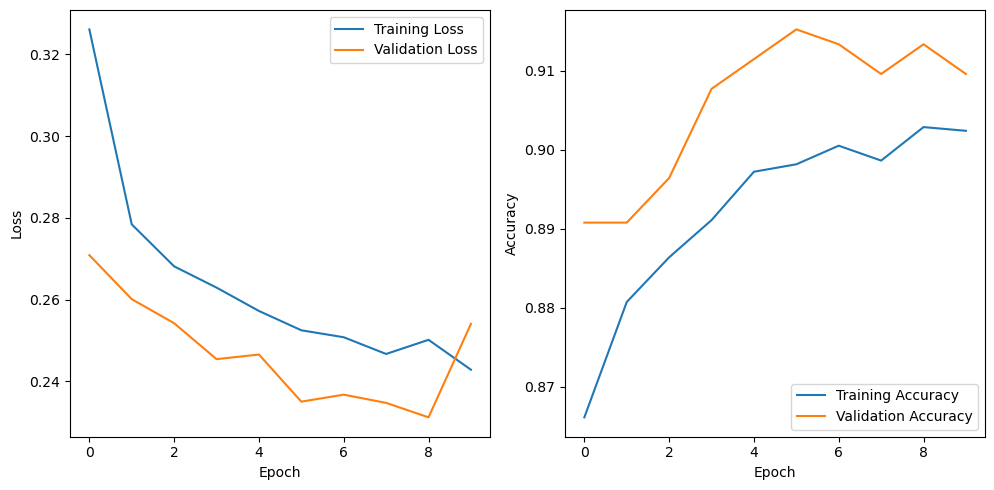

In [122]:
history = train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10, is_test=True
)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history["train_accuracy"], label="Training Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


plt.tight_layout()
plt.show()


In [114]:
print(history)

None
